# 440 final code
### outline 
1. imports
2. import data and process
*product of these operations is a thoroughly processed df 'nn_adata'*

3. sanity check

#### imports

In [17]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
from scipy import stats
print(np.__version__)
print(pd.__version__)
print(sc.__version__)
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
results_file = 'write/440.h5ad'



1.21.2
1.3.5
1.8.2
scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.21.2 scipy==1.8.0 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


In [16]:
# GET DATA AND PROCCESS

... reading from cache file cache/medullo_immune_cells-matrix.h5ad
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
filtered out 8363 genes that are detected in less than 3 cells


/Users/veronikapister/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
regressing out ['total_counts', 'pct_counts_mt']


/Users/veronikapister/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/Users/veronikapister/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'cell_types' as categorical
/Users/veronikapister/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute

    finished (0:00:07)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


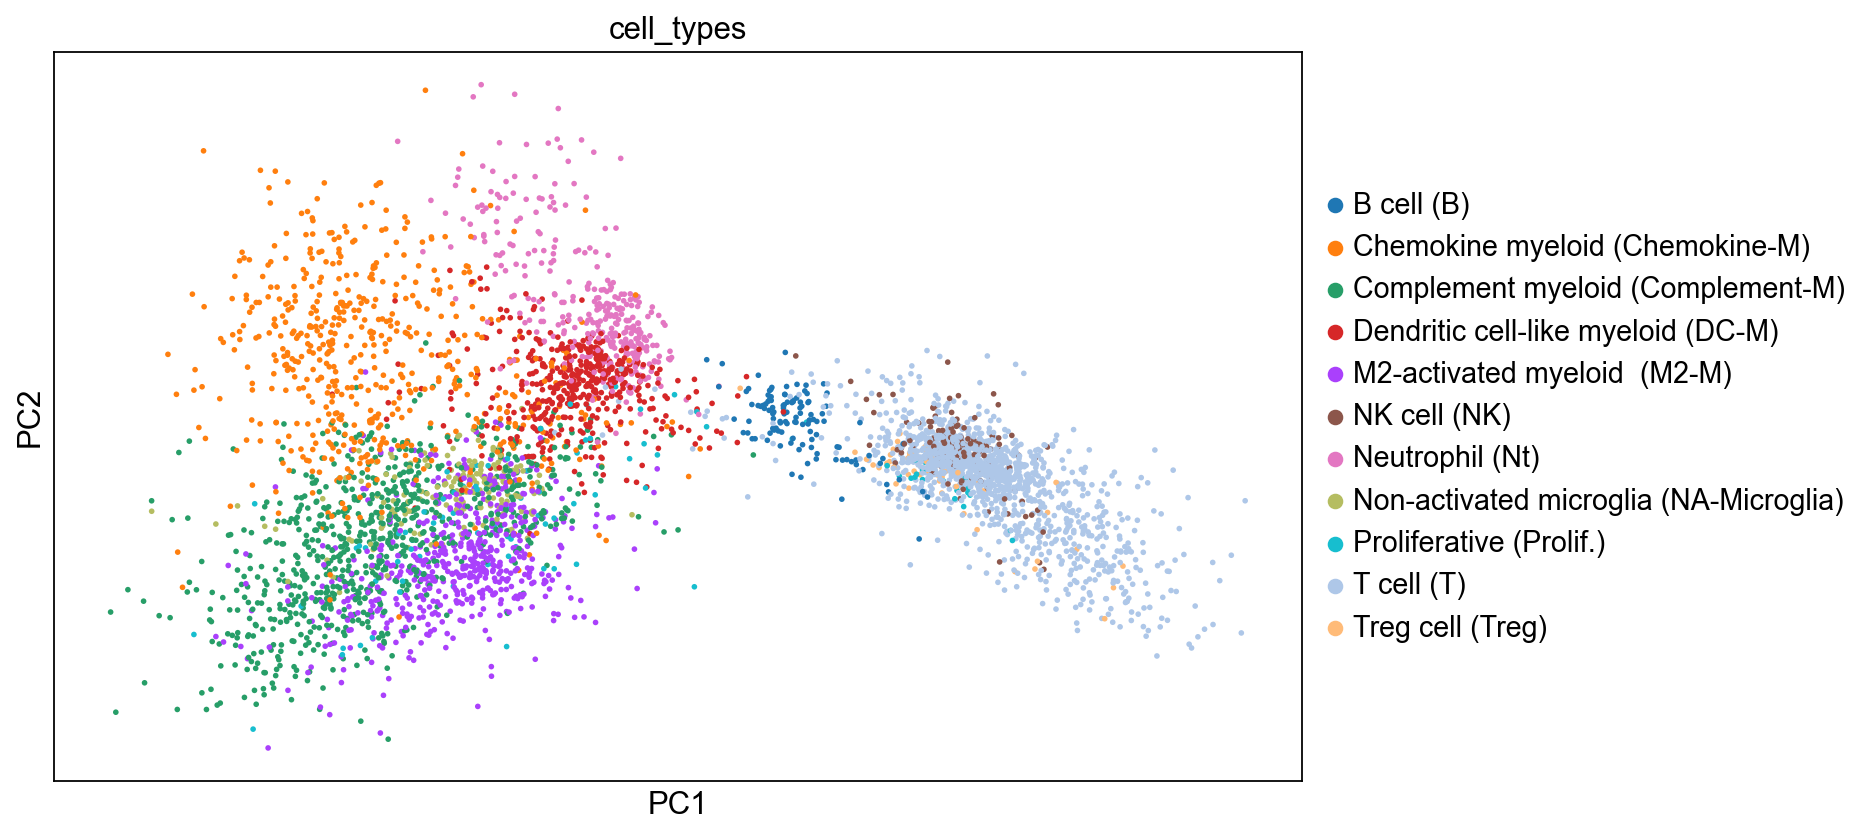

2022-05-15 19:08:16,438 - harmonypy - INFO - Iteration 1 of 10
2022-05-15 19:08:17,152 - harmonypy - INFO - Iteration 2 of 10
2022-05-15 19:08:17,880 - harmonypy - INFO - Iteration 3 of 10
2022-05-15 19:08:18,660 - harmonypy - INFO - Iteration 4 of 10
2022-05-15 19:08:19,368 - harmonypy - INFO - Iteration 5 of 10
2022-05-15 19:08:19,745 - harmonypy - INFO - Iteration 6 of 10
2022-05-15 19:08:20,182 - harmonypy - INFO - Iteration 7 of 10
2022-05-15 19:08:20,499 - harmonypy - INFO - Iteration 8 of 10
2022-05-15 19:08:21,253 - harmonypy - INFO - Iteration 9 of 10
2022-05-15 19:08:21,575 - harmonypy - INFO - Converged after 9 iterations


In [9]:
adata = sc.read(
    "medullo_immune_cells/matrix.csv", 
    cache=True)

# remove ALRA normalization performed by Riemondy et al
non_normalized = [data for data in adata.var.index if 'ALRA_' not in data]
nn_adata = adata[:, non_normalized]

# import the metadata
meta_df = pd.read_csv("meta.tsv", delimiter="\t", index_col = 0)
getem = ['cell_types','clusters','subgroup']

# merge meta data with the scRNA-seq df
w_meta = pd.merge(nn_adata.obs, 
                  meta_df[getem], 
                  right_index=True, 
                  left_index=True)
nn_adata.obs = w_meta
nn_adata.obs['batch'] = meta_df['UPN'].astype("category")

# perform standard scanpy noramlization
sc.pp.log1p(nn_adata)
sc.pp.highly_variable_genes(nn_adata, 
                            min_mean=0.0125, 
                            max_mean=3, 
                            min_disp=0.5)

# filter cells and genes by prevelance 
sc.pp.filter_cells(nn_adata, min_genes=200)
sc.pp.filter_genes(nn_adata, min_cells=3)

# annotate the group of mitochondrial genes as 'mt'
nn_adata.var['mt'] = nn_adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(nn_adata, 
                           qc_vars=['mt'], 
                           percent_top=None, 
                           log1p=False, 
                           inplace=True)

# more filtering of cells
nn_adata = nn_adata[nn_adata.obs.n_genes_by_counts < 5000, :]
nn_adata = nn_adata[nn_adata.obs.pct_counts_mt < 5.5, :]

# normalize data
sc.pp.normalize_total(nn_adata, target_sum=1e4)
nn_adata.raw = nn_adata

# highly variable genes only to perform clustering
nn_adata = nn_adata[:, nn_adata.var.highly_variable]
sc.pp.regress_out(nn_adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(nn_adata, max_value=10)

# perform pca to reduce dimensions
sc.tl.pca(nn_adata)#, svd_solver='arpack')
sc.pl.pca(nn_adata, color='cell_types', save=".png")
sce.pp.harmony_integrate(nn_adata, 'batch') # batch normalize

# above plot maps the cell types as they show up in the pca
# ideally cell types would generally cluster as the pca 
# will be the basis of the umap we generate next

##### Fig
above plot maps the cell types as they show up in the pca<br>
ideally cell types would generally cluster as the pca will be the basis of the umap we generate next

In [18]:
# RECREATING PAPER FIGURES

In [10]:
# summary: calculate the pvals for expression in different clusters
# given: a df of expression patterns in a given cell type across different clusters
#        a key such as 'leiden' for the breakdown according to clustering
# output: dataframe with p vals for each cluster
def mwu_stats (df, key):
    clusters = list(set(df.obs[key]))
    batch_to_sg = {'925': 'GP3', '945': 'GP3', '1028': 'GP3', '1130': 'GP3',
                   '1167': 'GP3', '1355': 'GP3', '1433': 'GP3', '753': 'GP4',
                   '934': 'GP4', '966': 'GP4', '996': 'GP4', '1066': 'GP4',
                   '1070': 'GP4', '1125': 'GP4', '1155': 'GP4', '1177': 'GP4',
                   '1195': 'GP4', '1238': 'GP4', '801': 'SHH', '831': 'SHH',
                   '877': 'SHH', '898': 'SHH', '1224': 'SHH', '1235': 'SHH',
                   '1325': 'SHH', '1397': 'SHH', '1416': 'SHH'
                  }
    batch_dict = {}
    for b in set(df.obs["batch"]):
        batch_df = df[df.obs["batch"] == b]
        batch_dict[b] = [len(batch_df[batch_df.obs[key] == c])/len(batch_df) for c in clusters]

    statstest = pd.DataFrame(index=["GP3/GP4 T val","GP3/GP4 p val", "GP4/SHH T val","GP4/SHH p val", "GP3/SHH T val","GP3/SHH p val"])
    for index in range(len(clusters)):
        sg_dict = {"GP3":[],"GP4":[],"SHH":[]}
        col = []
        for b in batch_dict:
            sg_dict[batch_to_sg[str(b)]].append(batch_dict[b][index])
        col.append(stats.mannwhitneyu(sg_dict["GP3"], sg_dict["GP4"])[0])
        col.append(stats.mannwhitneyu(sg_dict["GP3"], sg_dict["GP4"])[1])
        col.append(stats.mannwhitneyu(sg_dict["GP4"], sg_dict["SHH"])[0])
        col.append(stats.mannwhitneyu(sg_dict["GP4"], sg_dict["SHH"])[1])
        col.append(stats.mannwhitneyu(sg_dict["GP3"], sg_dict["SHH"])[0])
        col.append(stats.mannwhitneyu(sg_dict["GP3"], sg_dict["SHH"])[1])
        statstest[clusters[index]] = col
        if clusters[index] == '10':
            print(sg_dict)
    statstest = statstest.sort_index(axis=1)
    return statstest

In [15]:
# get expression data for each cluster for each cell type in a df
columns = list(set(nn_adata.obs['cell_types']))
rows = list(set(nn_adata.obs['subgroup']))
immune_cell_counts = pd.DataFrame(columns=columns, index=rows)
for ct in columns:
    for sg in rows:
        new_data = nn_adata[nn_adata.obs['subgroup'] == sg]
        new_data = new_data[new_data.obs['cell_types'] == ct]
        immune_cell_counts.loc[sg,ct] = len(new_data)

In [11]:
mwu_stats(nn_adata, "cell_types")

B cell (B)  Chemokine myeloid (Chemokine-M)  \
GP3/GP4 T val   20.500000                        55.000000   
GP3/GP4 p val    0.112055                         0.146483   
GP4/SHH T val   72.000000                        53.000000   
GP4/SHH p val    0.094142                         0.819038   
GP3/SHH T val   32.000000                        44.000000   
GP3/SHH p val    1.000000                         0.202675   

               Complement myeloid (Complement-M)  \
GP3/GP4 T val                          41.500000   
GP3/GP4 p val                           0.820421   
GP4/SHH T val                          28.000000   
GP4/SHH p val                           0.110076   
GP3/SHH T val                          17.000000   
GP3/SHH p val                           0.141608   

               Dendritic cell-like myeloid (DC-M)  \
GP3/GP4 T val                           36.000000   
GP3/GP4 p val                            0.855895   
GP4/SHH T val                           28.500000   
GP4/SHH p val                            0.119083   
GP3/SHH T val                           19.500000   
GP3/SHH p val                            0.221787   

               M2-activated myeloid  (M2-M)  NK cell (NK)  Neutrophil (Nt)  \
GP3/GP4 T val                     21.000000     30.000000        30.000000   
GP3/GP4 p val                      0.100001      0.478947         0.468509   
GP4/SHH T val                     11.000000     80.000000        66.000000   
GP4/SHH p val                      0.003757      0.022654         0.222398   
GP3/SHH T val                      1.000000     36.500000        39.500000   
GP3/SHH p val                      0.001267      0.633589         0.426582   

               Non-activated microglia (NA-Microglia)  \
GP3/GP4 T val                               26.000000   
GP3/GP4 p val                                0.262870   
GP4/SHH T val                               82.500000   
GP4/SHH p val                                0.008334   
GP3/SHH T val                               39.000000   
GP3/SHH p val                                0.367649   

               Proliferative (Prolif.)  T cell (T)  Treg cell (Treg)  
GP3/GP4 T val                37.500000   37.000000         28.000000  
GP3/GP4 p val                 0.962207    0.927800          0.333266  
GP4/SHH T val                37.500000   73.000000         53.000000  
GP4/SHH p val                 0.375927    0.080455          0.815857  
GP3/SHH T val                20.500000   48.000000         22.500000  
GP3/SHH p val                 0.262841    0.090734          0.336527

##### Table
the expression of cell types in different tumors
note that SHH shows high expression of M2-activated macrophages

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


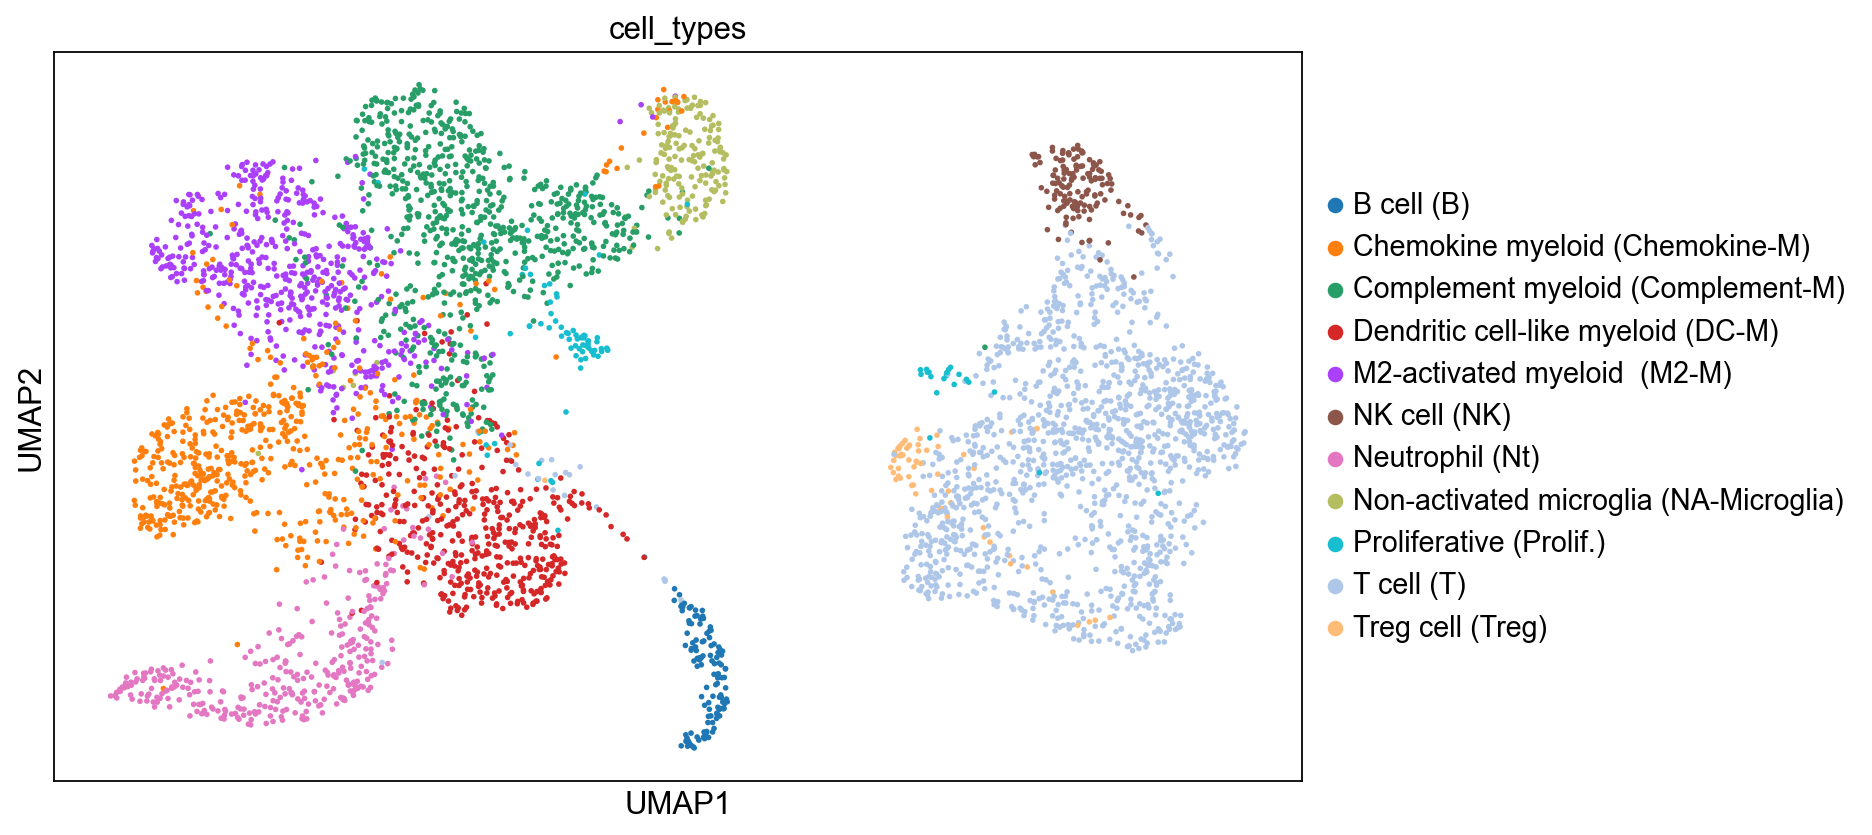

In [13]:
# calculate neighbors generate umap from Riemondy et al
sc.pp.neighbors(nn_adata, use_rep='X_pca', n_pcs = 12, n_neighbors = 20)
sc.tl.umap(nn_adata)
sc.set_figure_params(figsize=(10,6))
sc.tl.leiden(nn_adata, 0.4)
sc.pl.umap(nn_adata, color='cell_types')  
# generates a umap colored by Riemondy et al's cell types

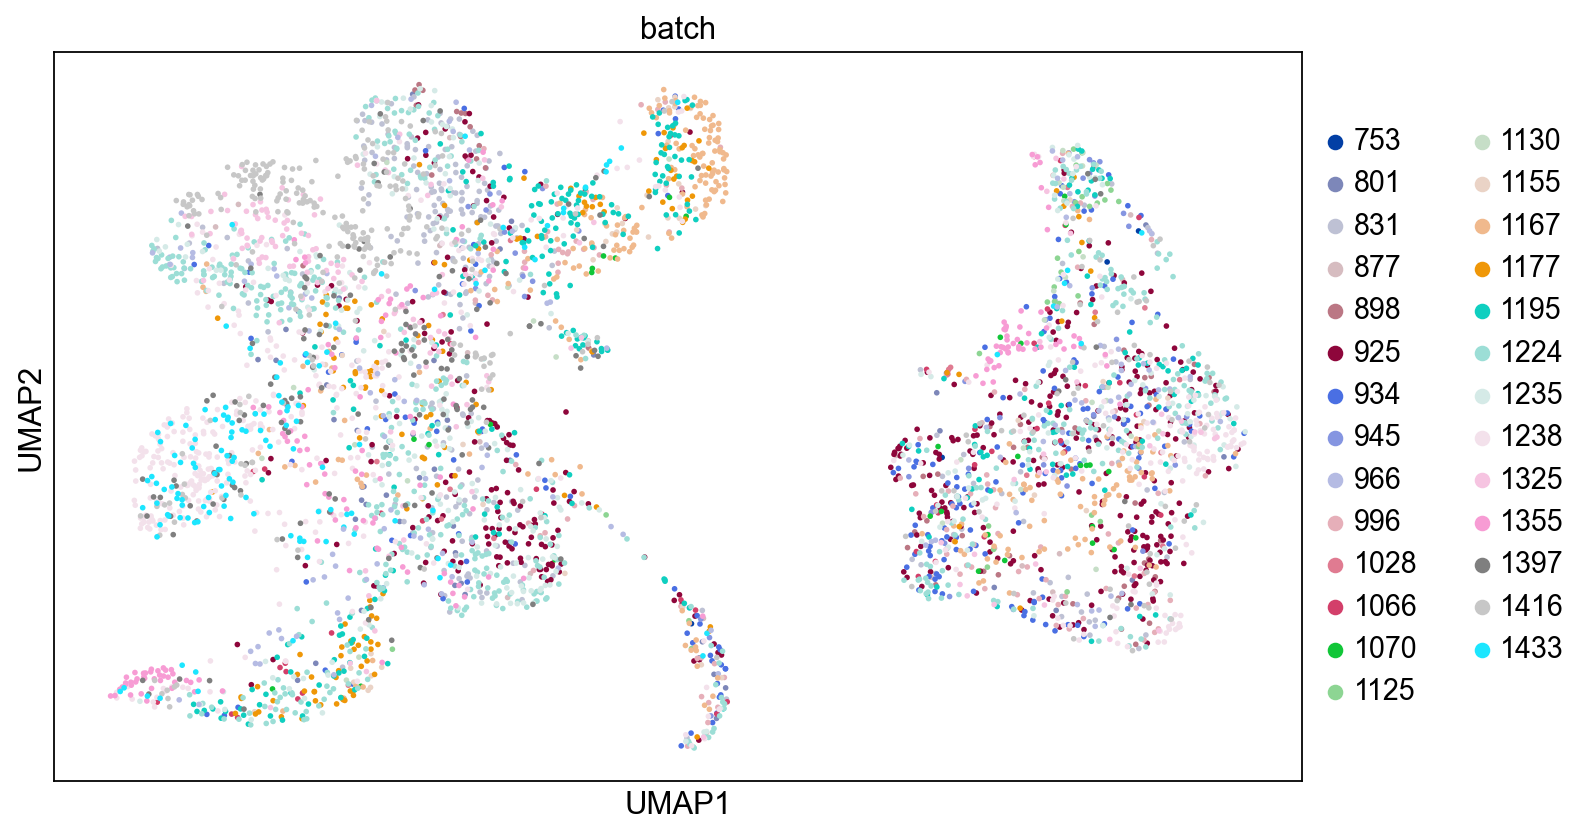

In [14]:
sc.pl.umap(nn_adata, color='batch') # generates a umap colored by patient number

In [27]:
# ***************************************

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


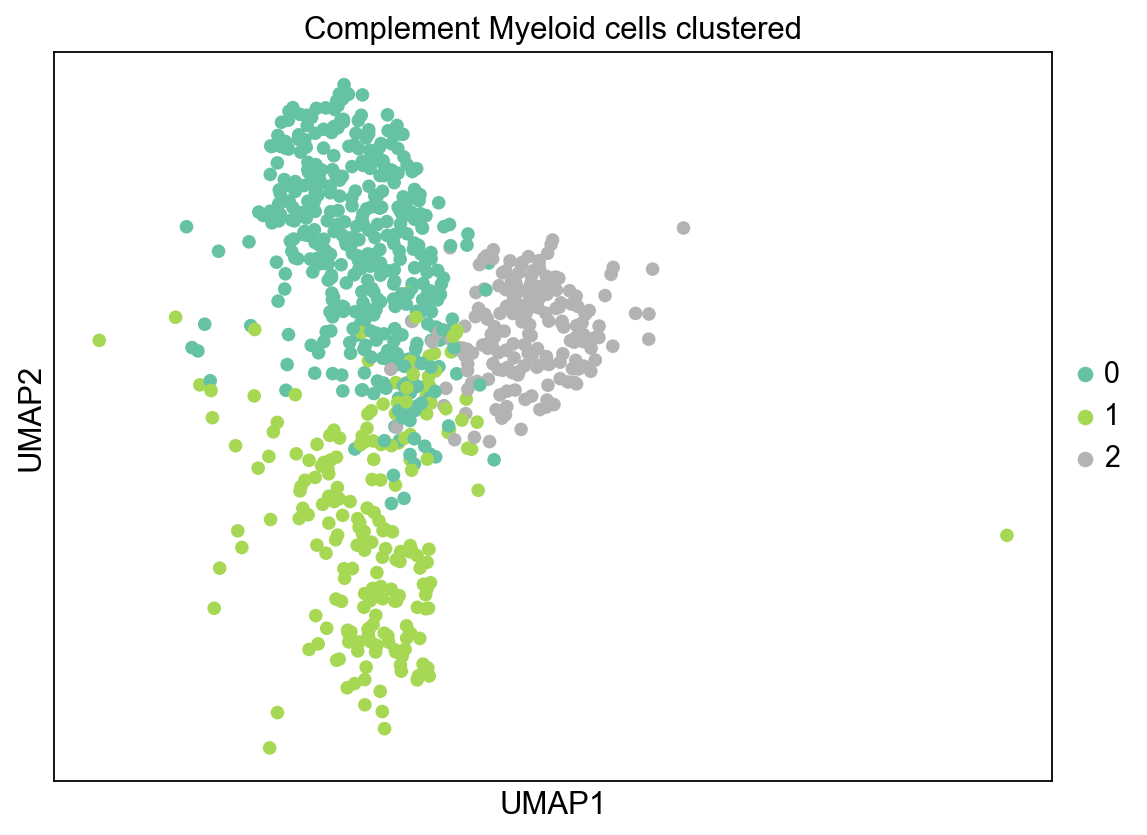

In [21]:
# COMPLEMENT MYELOID ANALYSIS

comp_myeloid = nn_adata[nn_adata.obs['cell_types'] == 'Complement myeloid (Complement-M)']
sc.set_figure_params(figsize=(8,6))
sc.pp.neighbors(comp_myeloid)
sc.tl.leiden(comp_myeloid, 0.3)

# plot complement myeloid into 3 subclusters
sc.pl.umap(comp_myeloid, palette="Set2", 
           color='leiden', 
           title="Complement Myeloid cells clustered")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


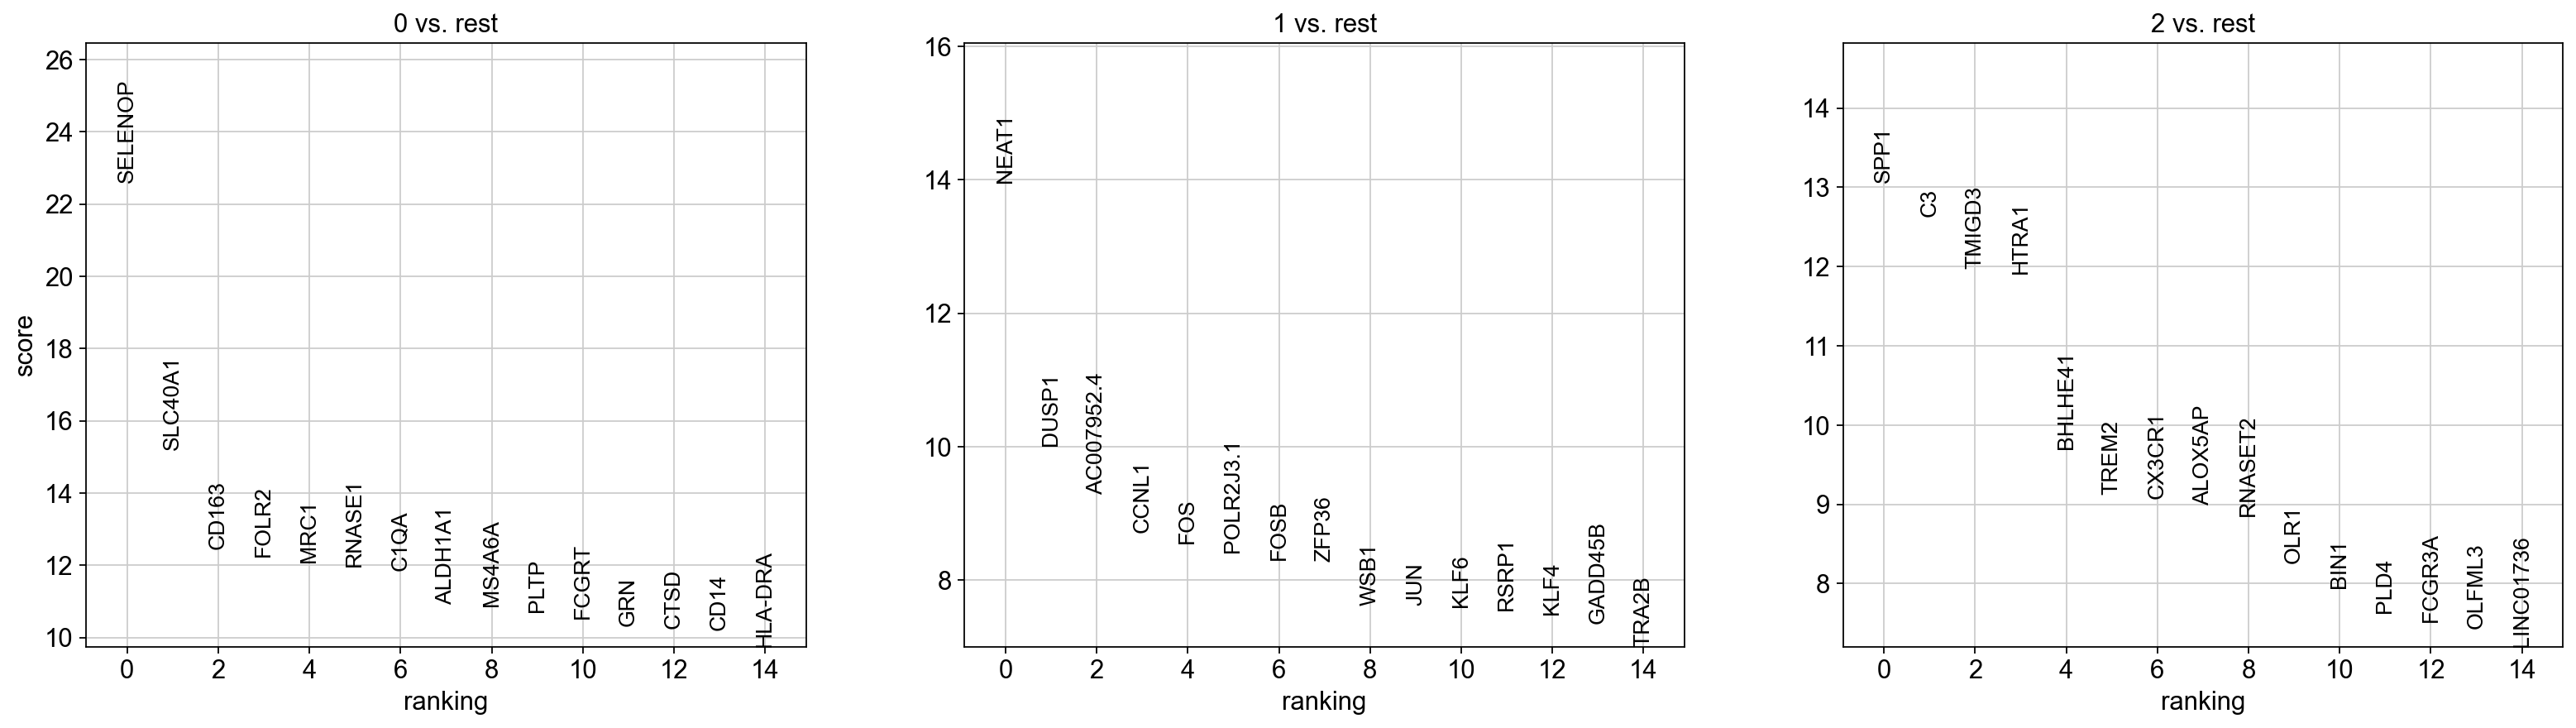

In [23]:

# rank the most upregualted genes in each cluster 
# plot the top 15 genes for each (Ben Hoch correction
sc.tl.rank_genes_groups(comp_myeloid, "leiden", method='t-test')
sc.pl.rank_genes_groups(comp_myeloid, 
                        n_genes=15, 
                        sharey=False, 
                        ncols=3, 
                        fontsize=12, 
                        save="comp_myeloid_top_genes.png")

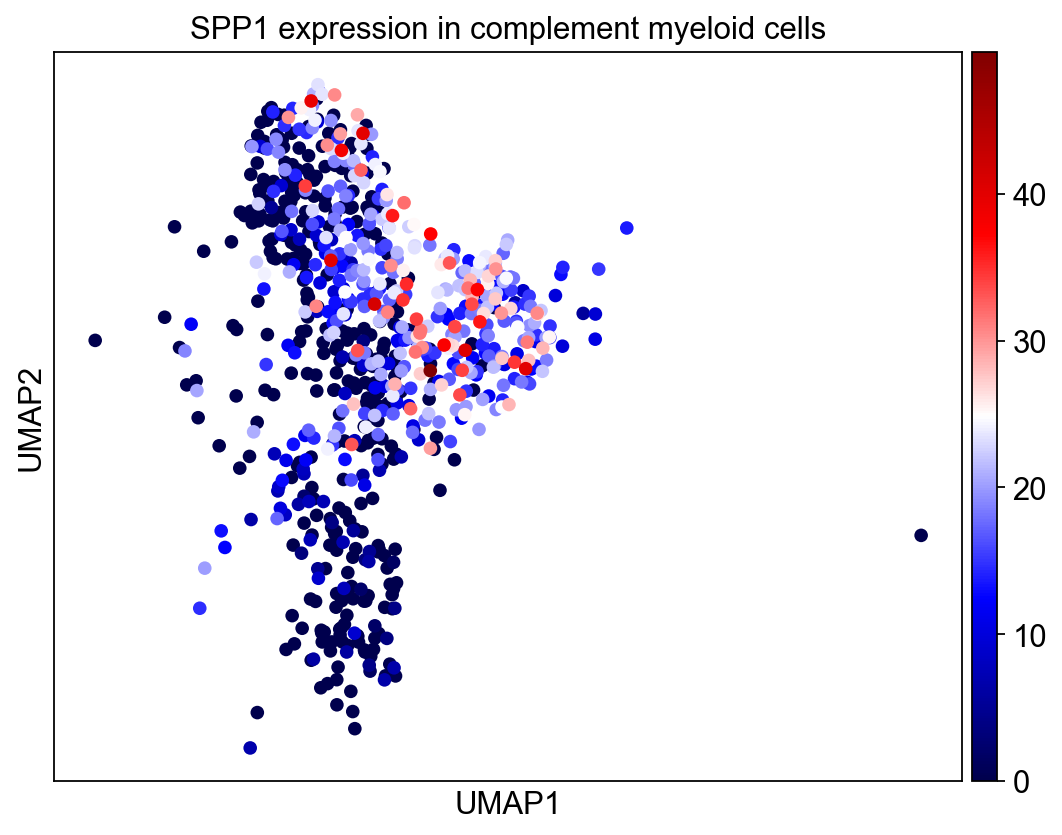

In [22]:

# plot SPP1 expression in complement myeloid cells (present in cluster 2)
sc.pl.umap(comp_myeloid, color='SPP1', 
           cmap="seismic", 
           title="SPP1 expression in complement myeloid cells")

running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


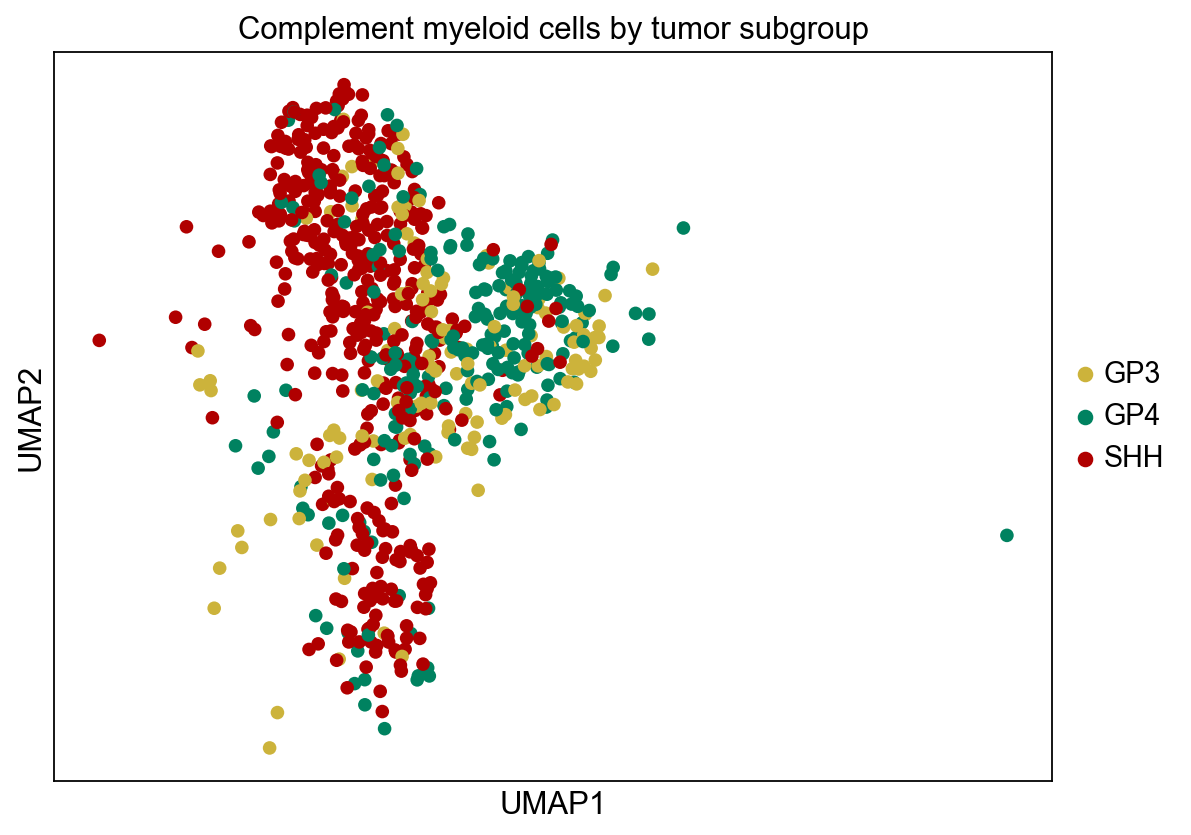

In [24]:

# plot the expression of each complement myeloid cell by tumor subgroup
# pallate is specific to reflect literature standards
sc.tl.leiden(comp_myeloid, 0.3)
sc.pl.umap(comp_myeloid, color="subgroup", palette=["#CCB33B", "#008260", "#B00000"], 
           save="_comp_myeloid_subgroup.png", 
           title="Complement myeloid cells by tumor subgroup")

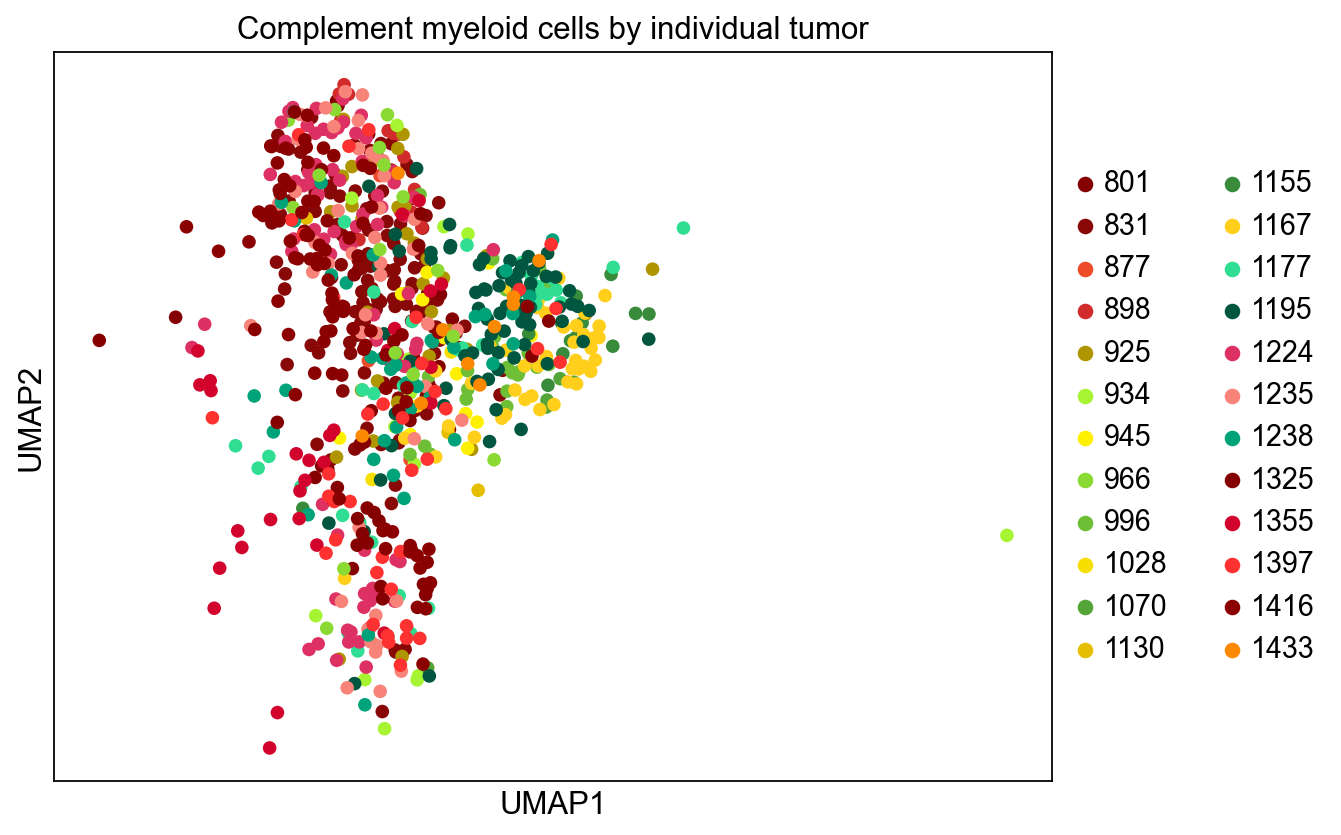

In [26]:

# there may be concerns about whether the blatant downregulation 
# of cluster 2 in SHH is a product of batch effect
# this plot shows the batches each as a slight variation of their parent colors
# (i.e. GP3 -> gold, GP4 -> green, SHH -> red)
# in one simple visual it's clear that no patient dominates this effect

batch_to_sg = {'1433': 'GP3', 
               '801': 'SHH', '831': 'SHH',
               '877': 'SHH', '898': 'SHH', '1224': 'SHH', '1235': 'SHH',
               '1325': 'SHH', '1397': 'SHH', '1416': 'SHH'
              }
pall_arr = ["#850000", "#880808", "#EE4B2B", "#D22B2B",
            "#AF9500", "#a7f432", "#fff000", "#8bda34",
            "#6fbf36", "#f6df00", "#54a538", "#e5be00",
            "#388b3b", "#ffcf1b", "#2FDE92", "#00563f",
            "#DE3163", "#F88379", "#00a379", "#850000",
            "#D2042D", "#FF3131", "#8B0000", "#fd8900"
           ]

# plot hue variations in a complement myeloid umap
sc.pl.umap(
    comp_myeloid, color='batch', palette=pall_arr,
    save="_comp_myeloid_leiden_batch.png", 
    title="Complement myeloid cells by individual tumor"
)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


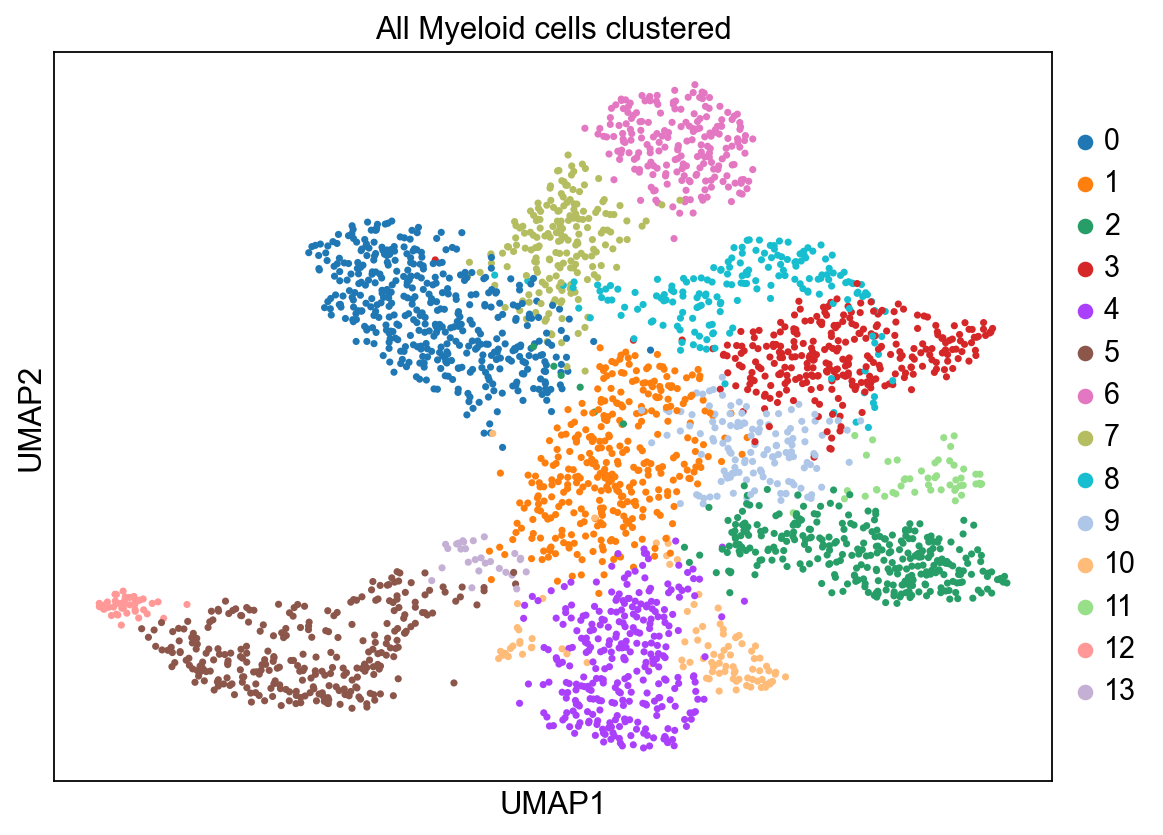

In [28]:
# ***************************************
# ALL MYELOID ANALYSIS
# ***************************************

# get dataframe of all myeloid immune cells
myeloid_labels = ['Complement myeloid (Complement-M)', 
                  'Dendritic cell-like myeloid (DC-M)', 
                  'M2-activated myeloid  (M2-M)',
                  'Chemokine myeloid (Chemokine-M)',
                  'Neutrophil (Nt)',
                  'Non-activated microglia (NA-Microglia)'
                 ]

myeloid_bools = [True if x in myeloid_labels else False for x in nn_adata.obs['cell_types']]
all_myeloid = nn_adata[myeloid_bools]

# analysis and clustering
sc.pp.neighbors(all_myeloid)
sc.tl.leiden(all_myeloid)
sc.tl.umap(all_myeloid)
# plot all myeloid cells by their sub clustering
sc.pl.umap(all_myeloid, color='leiden', 
           title="All Myeloid cells clustered")

In [30]:
# statistical analysis of expression patterns
mwu_stats(all_myeloid, 'leiden')

{'GP3': [0.0, 0.006024096385542169, 0.0, 0.49032258064516127, 0.0, 0.008, 0.09090909090909091], 'GP4': [0.0, 0.0, 0.038461538461538464, 0.11764705882352941, 0.011049723756906077, 0.0, 0.02564102564102564, 0.00267379679144385, 0.02702702702702703, 0.5], 'SHH': [0.0, 0.0, 0.027777777777777776, 0.0, 0.0, 0.007518796992481203, 0.01092896174863388, 0.0, 0.0]}


0          1         10         11         12  \
GP3/GP4 T val  52.000000  32.500000  29.500000  46.000000  39.000000   
GP3/GP4 p val   0.105191   0.845158   0.617946   0.267206   0.646282   
GP4/SHH T val  12.000000  21.500000  66.000000  45.000000  54.000000   
GP4/SHH p val   0.007691   0.060276   0.076804   1.000000   0.192976   
GP3/SHH T val  20.000000  13.500000  40.000000  39.000000  40.500000   
GP3/SHH p val   0.252273   0.063774   0.350748   0.414216   0.117783   

                      13          2          3          4          5  \
GP3/GP4 T val  41.500000  48.000000  33.000000  33.500000  14.000000   
GP3/GP4 p val   0.378678   0.153473   0.869719   0.922163   0.043089   
GP4/SHH T val  40.500000  44.000000  19.000000  34.500000  76.000000   
GP4/SHH p val   0.607149   0.954358   0.032747   0.413806   0.012607   
GP3/SHH T val  34.500000  42.500000   7.000000  26.500000  38.000000   
GP3/SHH p val   0.728103   0.201555   0.009863   0.633589   0.525054   

                       6          7          8          9  
GP3/GP4 T val  21.000000  25.500000  25.000000  40.000000  
GP3/GP4 p val   0.182232   0.369306   0.249993   0.649076  
GP4/SHH T val  78.000000  67.000000  18.000000  53.000000  
GP4/SHH p val   0.005026   0.071823   0.026493   0.517378  
GP3/SHH T val  44.500000  42.000000   4.000000  44.000000  
GP3/SHH p val   0.128411   0.269164   0.002850   0.192158

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


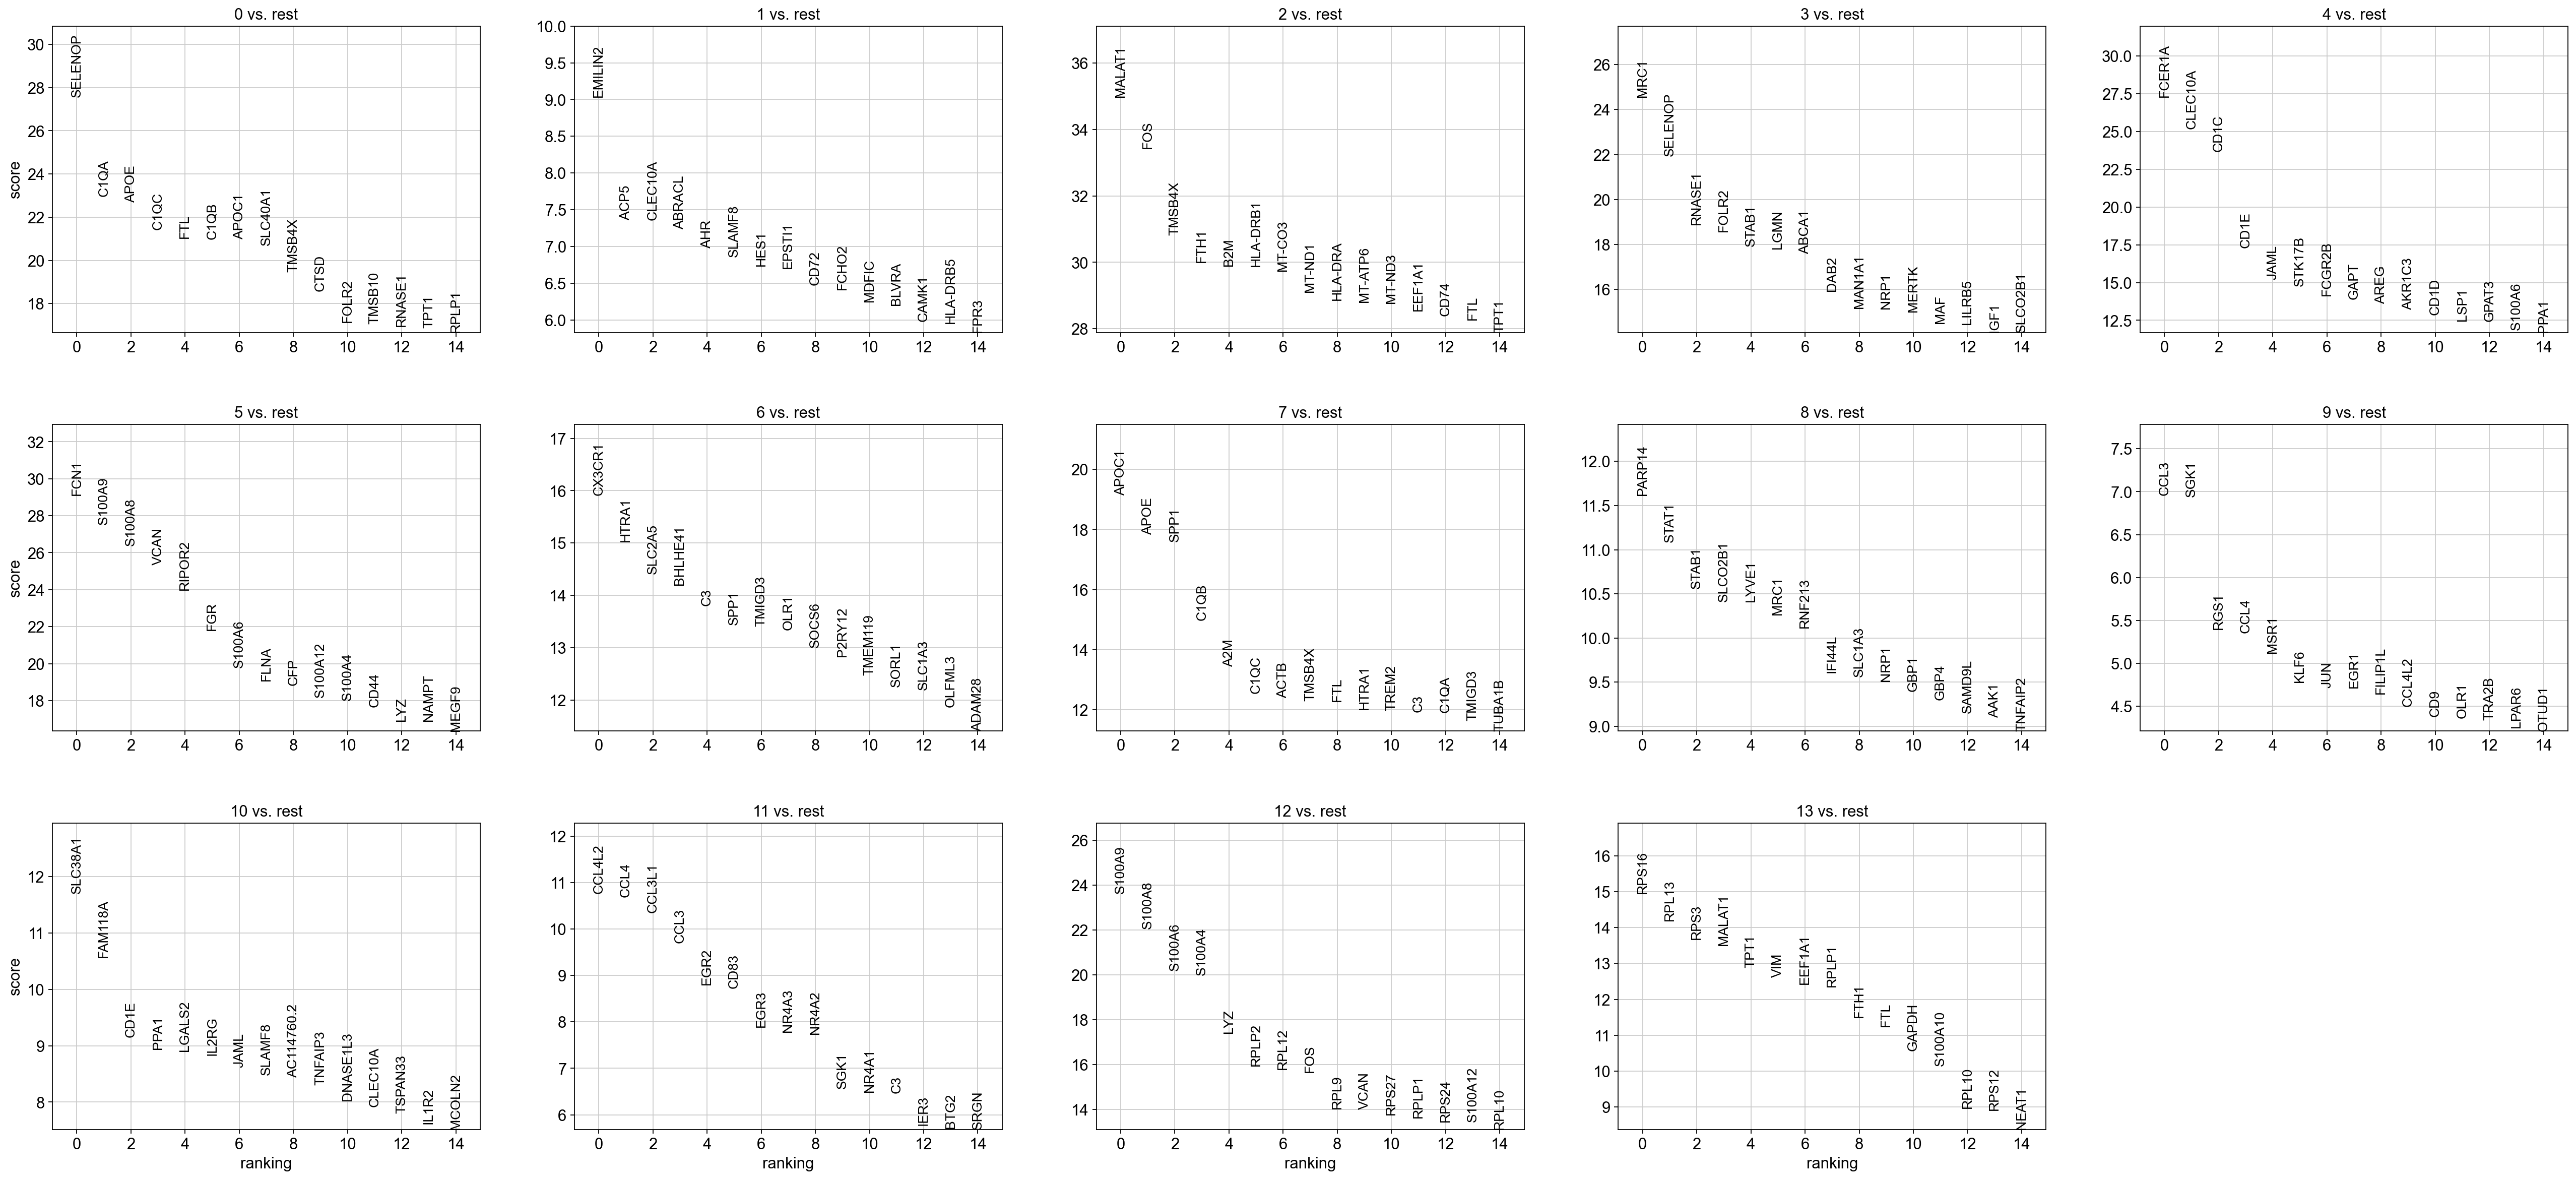

In [31]:

# rank the top 15 most upregulated in each cluster for all 14 clusters
sc.tl.rank_genes_groups(all_myeloid, "leiden", method='t-test')
sc.pl.rank_genes_groups(all_myeloid, n_genes=15, 
                        sharey=False, ncols=5, 
                        fontsize=12, 
                        save="all_myeloid_top_genes.png")

In [42]:
# summary: quickly visualize the differential expression of each interesting cluster
# input: cluster_num is simply the string of the cluster # of interest
# output: two plots (1) umap colored by tumor subgroup, 
#                   (2) umap colored by patient number
def plot_cluster(cluster_num):
    cluster_data = all_myeloid[all_myeloid.obs['leiden'] == cluster_num]

    # plot cluster's tumor type representation
    sc.pl.umap(cluster_data, color='subgroup', size=95, 
               title="Cluster " + cluster_num + " by subgroup")

    # plot cluster's patient distribution
    sc.pl.umap(cluster_data, color='batch', size=95, 
               title="Cluster " + cluster_num + " by patient number")

Trying to set attribute `._uns` of view, copying.


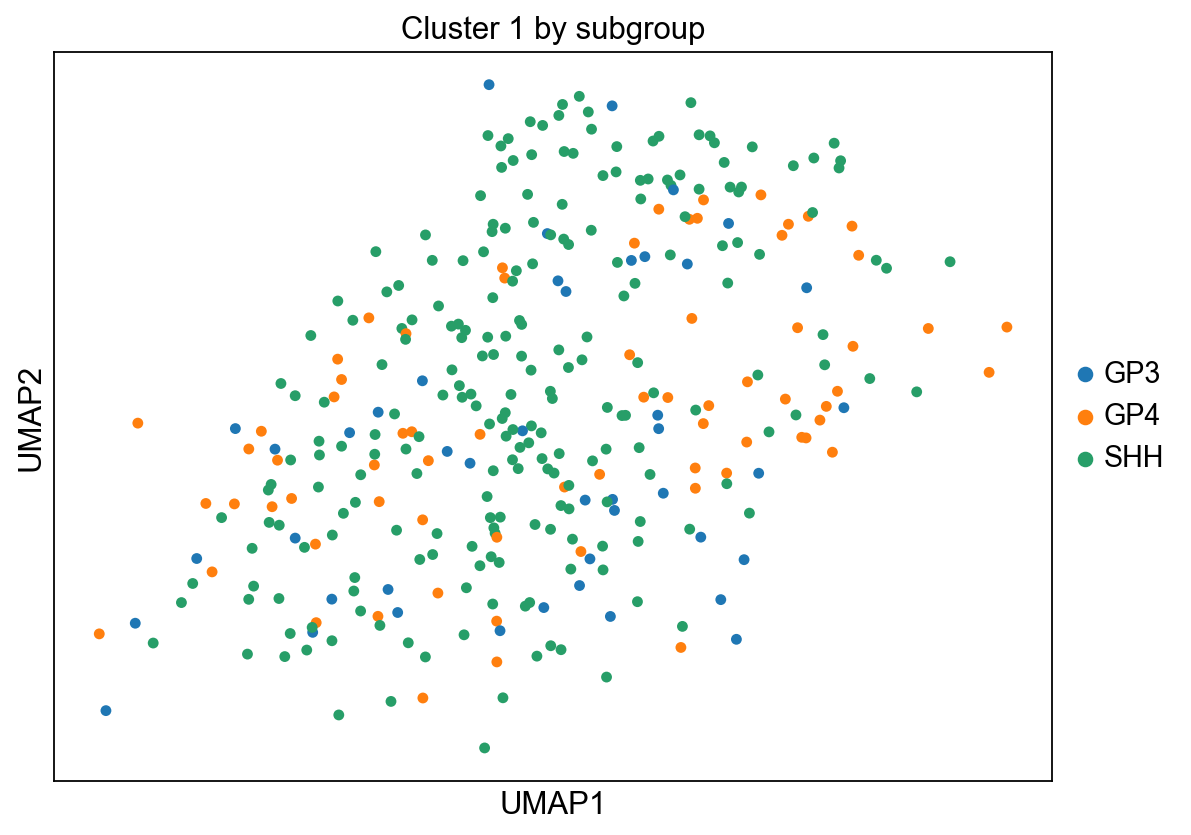

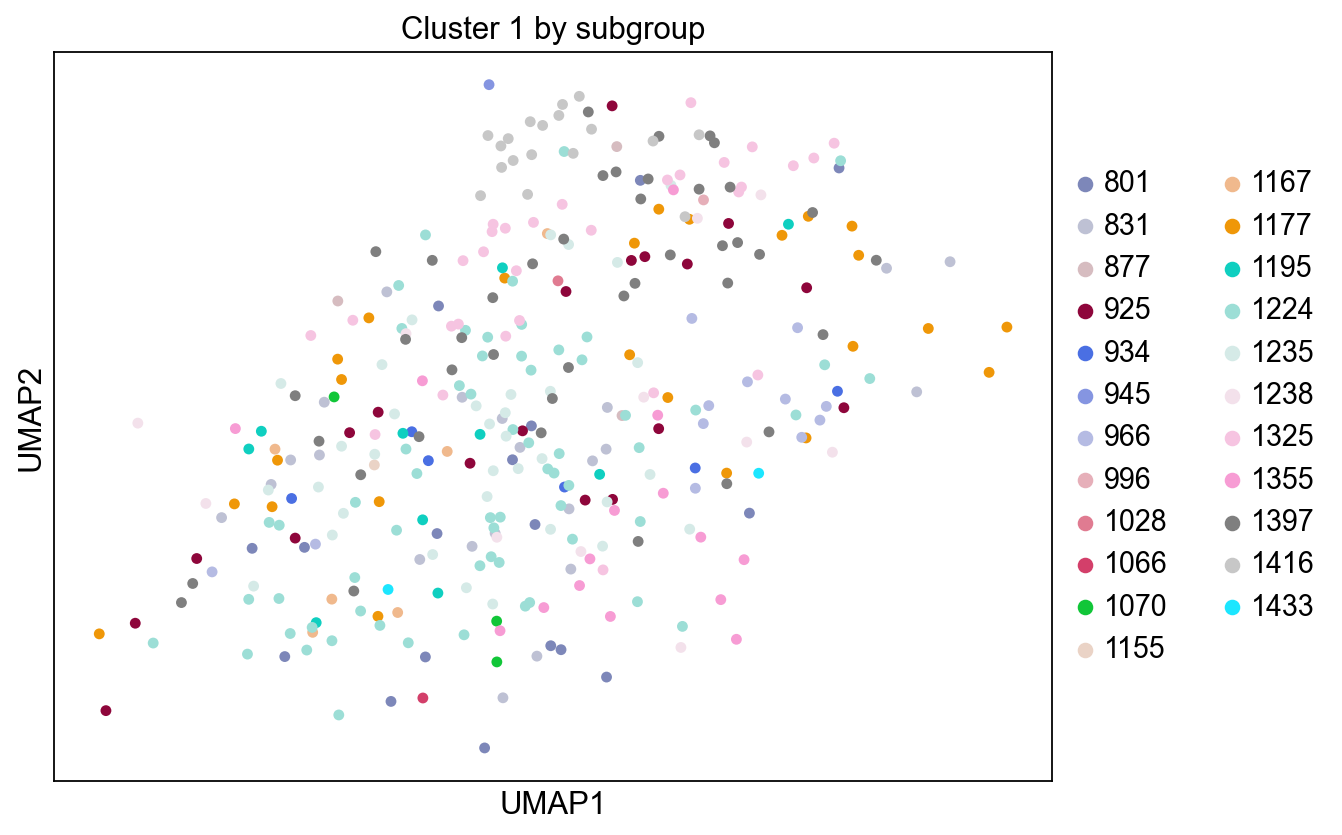

In [39]:
# CLUSTER 1
plot_cluster('1')

Trying to set attribute `._uns` of view, copying.


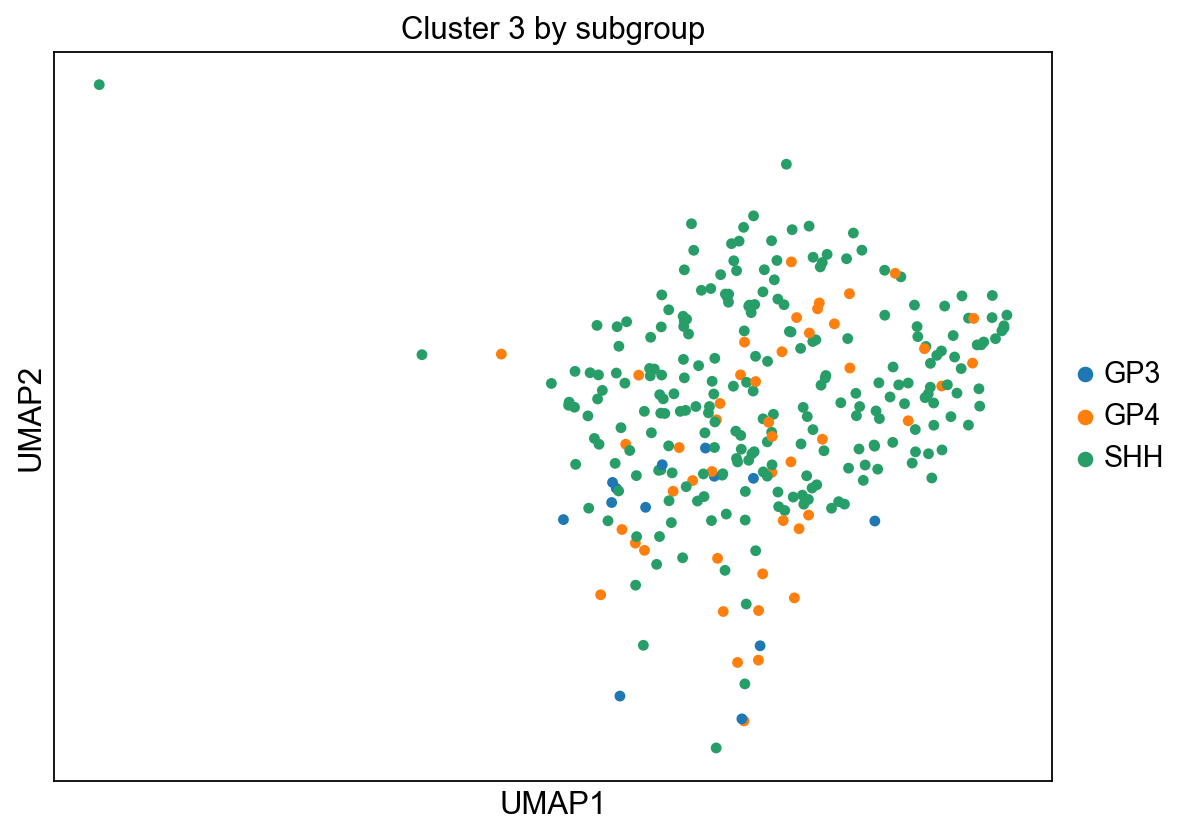

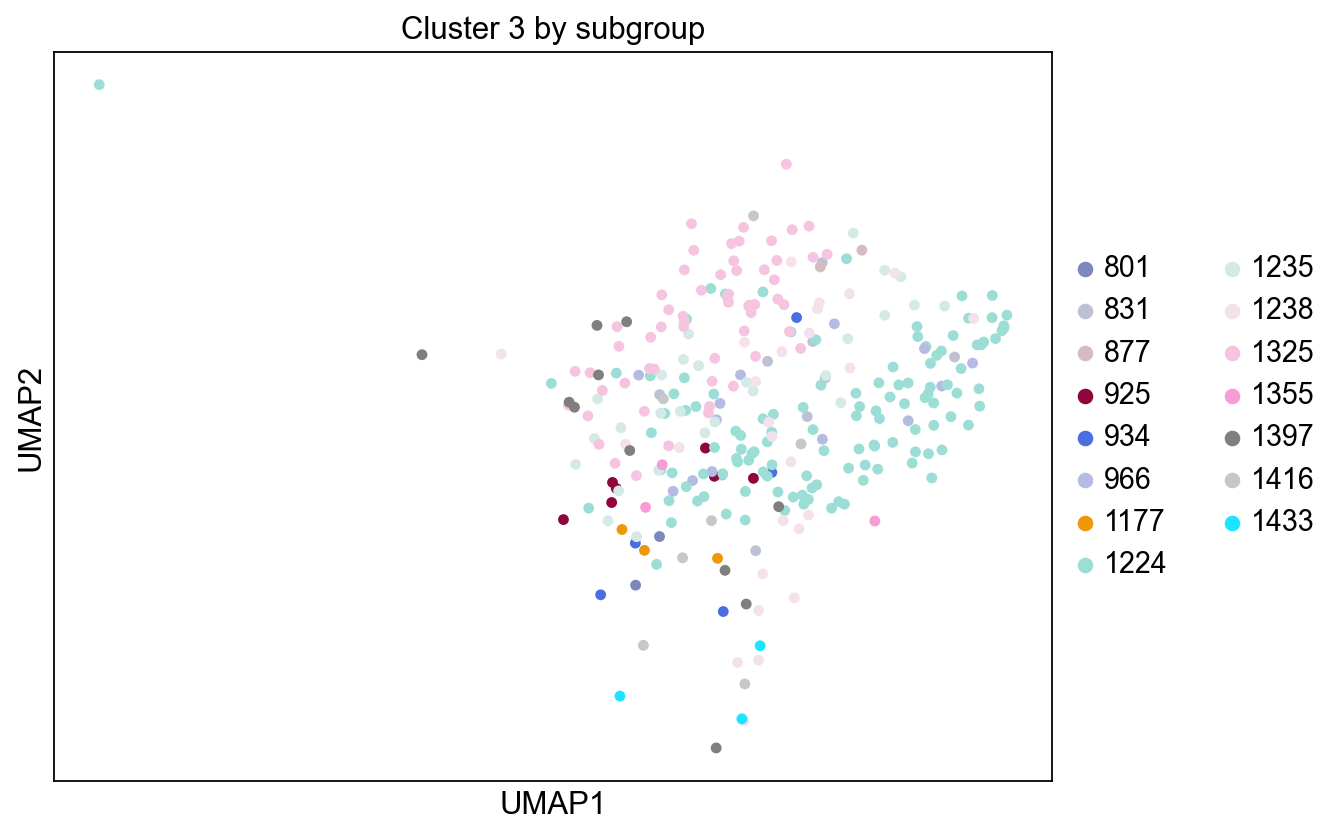

In [40]:
# CLUSTER 3
plot_cluster('3')

Trying to set attribute `._uns` of view, copying.


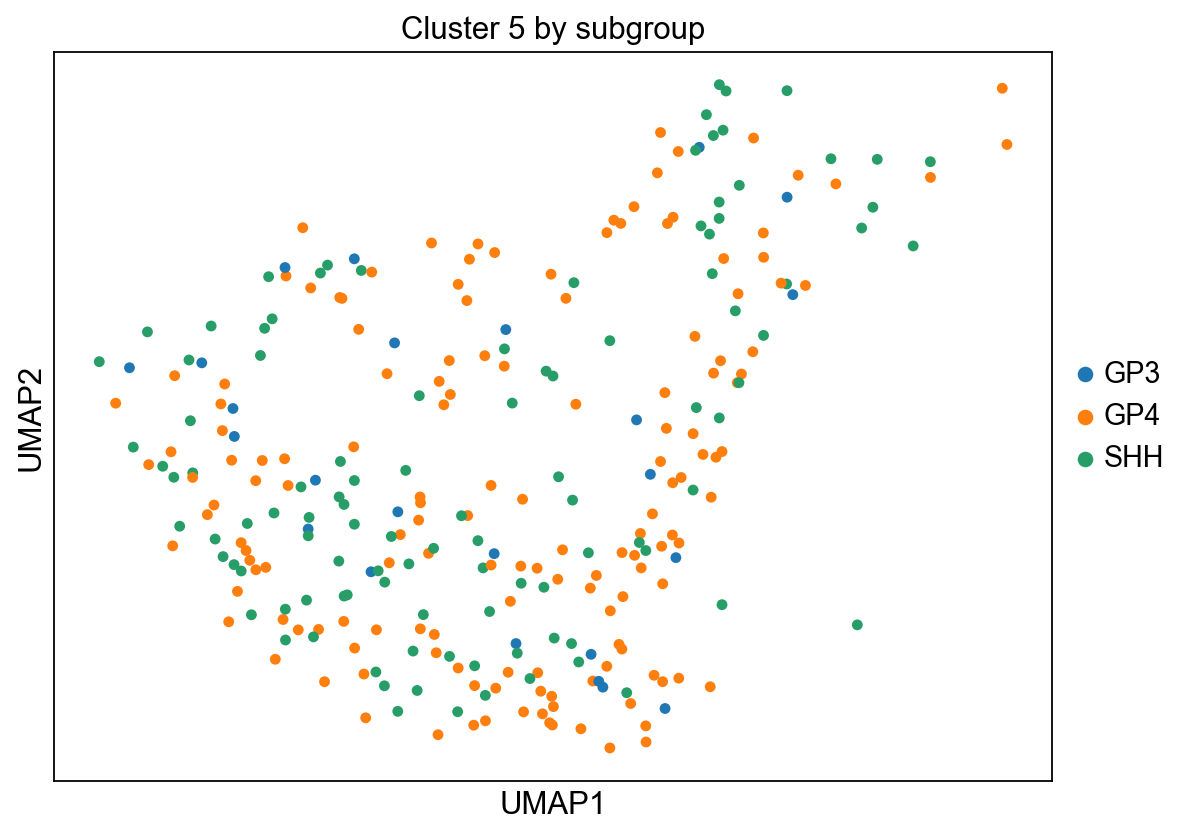

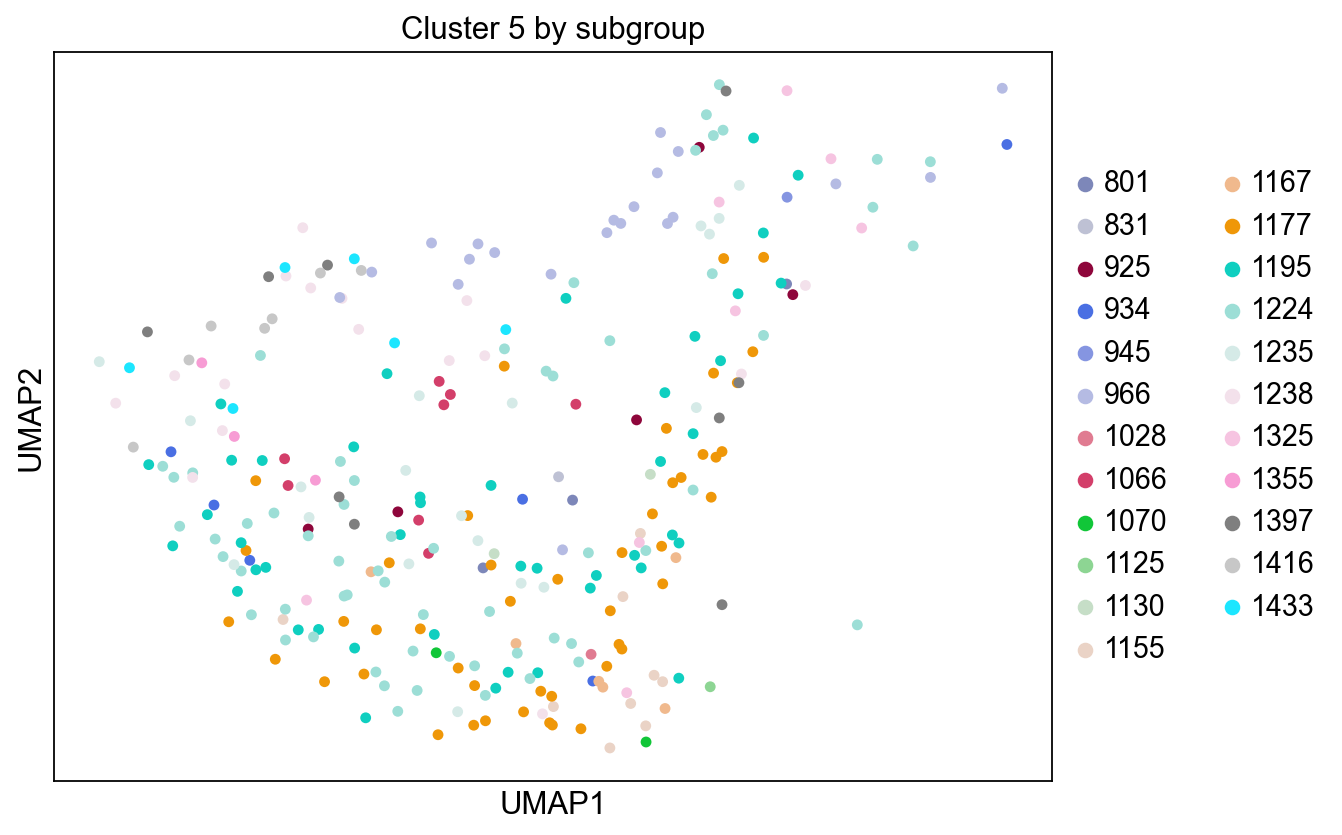

In [41]:
# CLUSTER 5
plot_cluster('5')